In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/train-00000-of-00001.parquet'

In [5]:
import pandas as pd

df = pd.read_parquet(file_path)
df.head()

,text,labels
0,"Tempalqin, baralqin, miqren, elm, təhsil",neutral
1,"Başa düşmürəm, mən o vaxt onlardan necə gedə b...",negative
2,Taksto fener en sonuncu para kubok qazanivaosk...,neutral
3,Halal olsun admin heyyətinə. Tək tük səhifələr...,positive
4,Dunya seyaheti etmek ucun limitsiz bilet ve pul,positive


In [6]:
df = df[df['labels'].isin(["positive", "negative"])].copy()
df['labels'] = df['labels'].map({"negative": 0, "positive": 1})

In [7]:
print(df['labels'].value_counts())

labels
0    14000
1    14000
Name: count, dtype: int64


In [8]:
# 1. Dosya yolu
corrections_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/word_correction_dict_2.xlsx'

# 2. Excel dosyasını oku
corrections_df = pd.read_excel(corrections_path)

# 3. Sözlük oluştur
replace_dict = dict(zip(corrections_df['Column1'], corrections_df['Column2']))

In [9]:
# 1. Sözlük düzeltmesini uygula
def apply_corrections(text):
    return ' '.join([replace_dict.get(word, word) for word in text.split()])

df_corrected = df.copy()
df_corrected['text'] = df_corrected['text'].apply(apply_corrections)

# 2. Ön işlemeleri uygula
import re

def basic_cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)     # web linklerini sil
    text = re.sub(r'\){2,}', '', text)                    # 2+ parantezi sil
    text = re.sub(r'\s{2,}', ' ', text)                   # çoklu boşlukları tek boşluk yap
    return text.strip()

df_cleaned = df_corrected.copy()
df_cleaned['text'] = df_cleaned['text'].apply(basic_cleaning)

In [10]:
from sentence_transformers import SentenceTransformer

# LaBSE modelini yükle
model = SentenceTransformer('sentence-transformers/LaBSE')

# Temizlenmiş metinleri al
texts = df_cleaned['text'].tolist()

# Embedding çıkar (batch size isteğe göre artırılabilir)
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Batches:   0%|          | 0/438 [00:00<?, ?it/s]

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_cleaned['labels'])

# İstersen sınıf isimlerini görelim
print(label_encoder.classes_)

[0 1]


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [13]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbosity=1
)

clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

    negative       0.77      0.81      0.79      2800
    positive       0.80      0.76      0.78      2800

    accuracy                           0.78      5600
   macro avg       0.78      0.78      0.78      5600
weighted avg       0.78      0.78      0.78      5600

Confusion Matrix:
[[2266  534]
 [ 681 2119]]


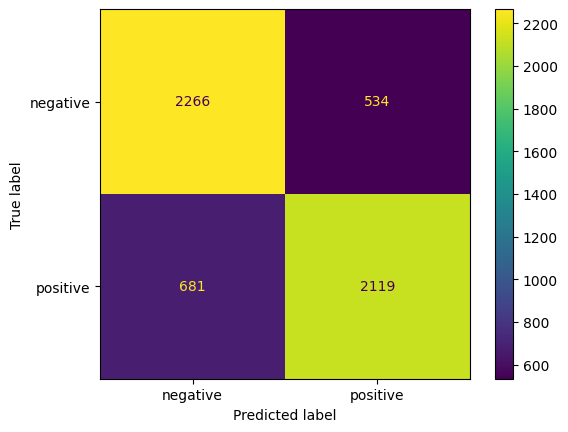

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Test verisi için tahmin yap
y_pred = clf.predict(X_test)

# Sınıf isimlerini manuel olarak belirle (çünkü 0 ve 1 string değil)
target_names = ["negative", "positive"]

# Sınıflandırma raporu
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix yazdır
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Opsiyonel: Confusion matrix görselleştirme
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()

In [ ]:
import numpy as np

# 'negative' olarak gerçeklenmiş ama 'positive' tahmin edilmiş indeksler
false_pos = np.where(
    (y_test == label_encoder.transform(['negative'])[0]) &
    (y_pred == label_encoder.transform(['positive'])[0])
)[0]


In [ ]:
for i in false_pos[:10]:
    print(df_cleaned.iloc[i]['text'])


İntiqamınızı igid şəhitlərimuz,qazilərimiz əsgərlərimuz aldı,ruhun şad olsun
Su girdi qaba oldu icmelini bu qurum su girdi yerin altina oldu mənim kimi basa dusubdu
Sən istəyirdin pul yığıb, sındırdığın fincanı alasan?
Yıllar dır tadı və lezzetini bozmayan mekan ən uygun fiyat və lezzet bor arada hər zaman targovide olmak istediğimiz mekan
Saakyan Ağdərədə 43 şəxsin saxta nikahı üzərində pul qazanıb.
Bizim ölkədə de cixire amma Xalqcun deyil Kimse wexsi Abyekti kimi özü üçün cixarir
“Ü-ü-ü, kartoçkalarımı itirmişəm”
Yelena diqqətlə ora baxdı, birdən mənə tərəf dönüb yalvara-yalvara dedi.
Ermənistan hökumətinin tələbi ilə Rusiya hərbi bazalarının Ermənistandan çıxarılması mümkündür.
Bahram Rajabzadeh yadinda donərlər duzəldirdim sənə
